# Homework 2: Linear Models for Regression and Classification

Due 10/21 at 11:59pm

In this notebook, we will be implementing three linear models: linear regression, logistic regression, and SVM. We will see that despite some of their differences at the surface, these linear models (and many machine learning models in general) are fundamentally doing the same thing - that is, optimizing model parameters to minimize a loss function on data.

**Note: There are two notebooks in Homework 2. Please also complete the other notebook `HW2_Decision_Trees.ipynb` for full credit on this assignment.**

![comic](https://pbs.twimg.com/media/ESlslPWWkAAcNP-?format=jpg&name=900x900)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import LinearSVC

## Part 1: Linear Regression

### 1.1 Data Exploration

In part 1, we will use two datasets to train and evaluate our linear regression model. 

The first dataset will be a synthetic dataset sampled from the following equations:

$$
\epsilon \sim \text{Normal}(0, 3) \\
y = 3x + 10 + \epsilon
$$

In [2]:
np.random.seed(0)
epsilon = np.random.normal(0, 3, 100)   # Sample epsilon from a Normal distribution
x = np.linspace(0, 10, 100)             # Sample x evenly between 0 and 100
y = 3 * x + 10 + epsilon

Note that the above dataset satisfies all the assumptions of a linear regression model:
- Linearity: $y$ is a linear (technically affine) function of $x$.
- Independence: the $x$'s are independently drawn, and not dependent on each other.
- Homoscedasticity: the $\epsilon$'s, and thus the $y$'s, have constant variance.
- Normality: the $\epsilon$'s are drawn from a Normal distribution (i.e. Normally-distributed errors)

These properties, as well as the simplicity of this dataset, will make it a good test case to check if our linear regression model is working properly.

**Plot y vs x in the synthetic dataset as a scatter plot. Label your axes and make sure your y-axis starts from 0.**

Text(0.5, 1.0, 'Scatterplot of y vs x')

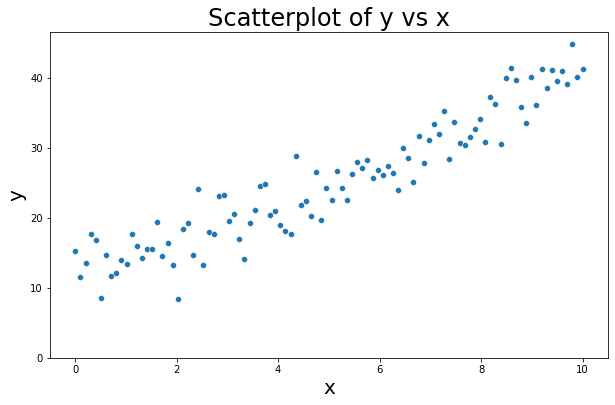

In [3]:
### Your code here
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(x = x,y = y)
plt.ylim(0)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.title('Scatterplot of y vs x', fontsize=24)


The second dataset we will be using is an [auto MPG dataset](https://archive.ics.uci.edu/ml/datasets/Auto+MPG). This dataset contains various characteristics for around 400 cars. We will use linear regression to predict the mpg label from seven features (4 continuous, 3 discrete).

In [4]:
# Load auto MPG dataset
auto_mpg_df = pd.read_csv('auto-mpg.csv')

# drop some rows with missing entries
auto_mpg_df = auto_mpg_df[auto_mpg_df['horsepower'] != '?']
# Cast horsepower column to float
auto_mpg_df['horsepower'] = auto_mpg_df['horsepower'].astype(float)

auto_mpg_df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [5]:
# Split data into features and labels
auto_mpg_X = auto_mpg_df.drop(columns=['mpg'])
auto_mpg_y = auto_mpg_df['mpg']

**Plot the distribution of the label (mpg) using a histogram.**

Text(0.5, 1.0, 'Histogram of mpg')

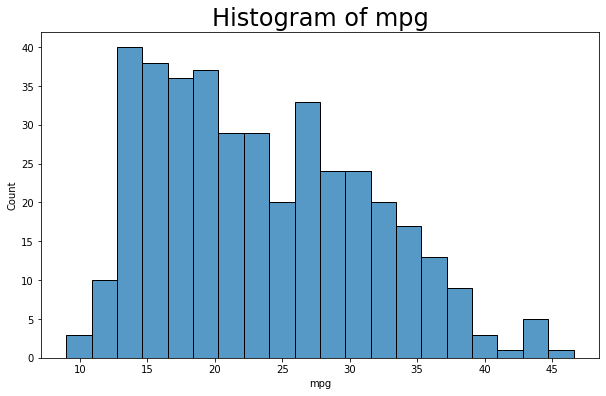

In [6]:
### Your code here
plt.figure(figsize=(10, 6))
sns.histplot(auto_mpg_y, bins = 20)
plt.title('Histogram of mpg', fontsize=24)

**Plot the relationships between the label (mpg) and the continuous features (displacement, horsepower, weight, acceleration) using a small multiple of scatter plots. Make sure to label the axes.**

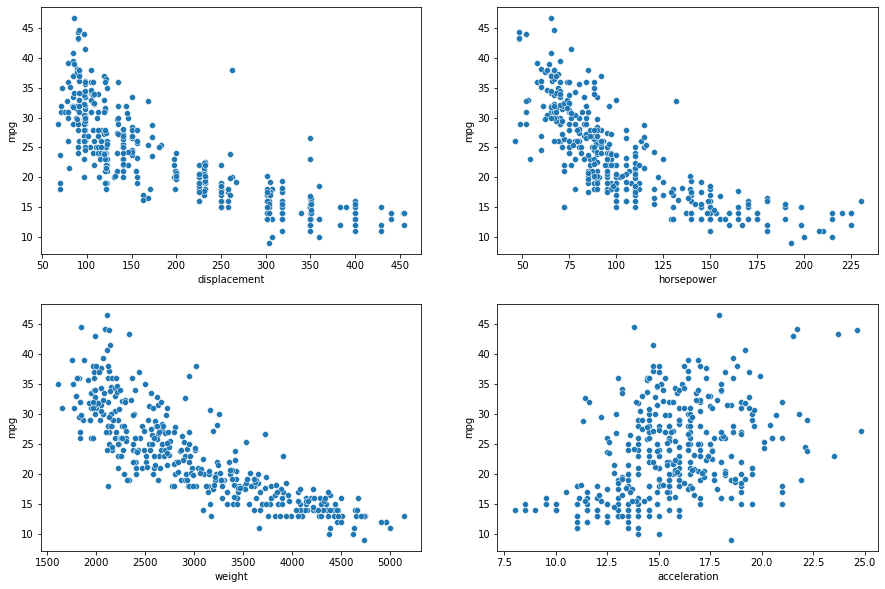

In [7]:
### Your code here
continuous_fea = ["displacement","horsepower","weight","acceleration"]
fig, ax = plt.subplots(2,2,figsize = (15,10))
for var, subplot in zip(continuous_fea, ax.flatten()):
    sns.scatterplot(x = var, y = auto_mpg_y, data = auto_mpg_df, ax = subplot)


**Plot the relationships between the label (mpg) and the discrete features (cylinders, model year, origin) using a small multiple of box plots. Make sure to label the axes.**

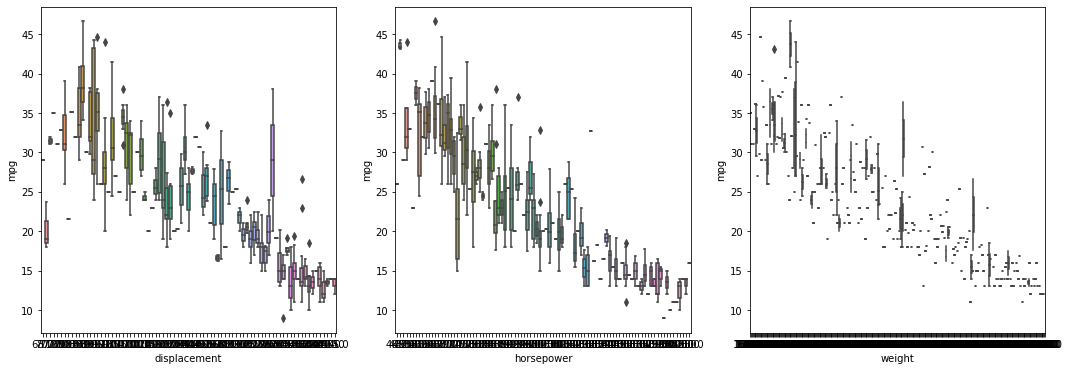

In [8]:
### Your code here
discrete_fea = ["cylinders","model year","origin"]
fig, ax = plt.subplots(1,3,figsize = (18,6))
for var, subplot in zip(continuous_fea, ax.flatten()):
    sns.boxplot(x = var, y = auto_mpg_y, data = auto_mpg_df, ax = subplot)


**From the visualizations above, do you think linear regression is a good model for this problem? Why and/or why not?**

In [9]:
### Your answer here
'''
I think linear regression will be a good model for this problem since the target variable seems to have strong relationships
with other features in this data set. Also, the other variables are independent and homoscedasticity seems to hold from the 
scatterplots. Although the distribution of the target variable seems to violate the normality assumption, we can actually 
log-transform or use other transformation, such as Box Cox transformation, to make the distribution normal. 
'''

'\nI think linear regression will be a good model for this problem since the target variable seems to have strong relationships\nwith other features in this data set. Also, the other variables are independent and homoscedasticity seems to hold from the \nscatterplots. Although the distribution of the target variable seems to violate the normality assumption, we can actually \nlog-transform or use other transformation, such as Box Cox transformation, to make the distribution normal. \n'

### 1.2 Data Pre-processing

Before we can fit a linear regression model, there are several pre-processing steps we should apply to the datasets:
1. Encode categorial features appropriately.
2. Split the dataset into training (60%), validation (20%), and test (20%) sets.
3. Standardize the columns in the feature matrices X_train, X_val, and X_test to have zero mean and unit variance. To avoid information leakage, learn the standardization parameters (mean, variance) from X_train, and apply it to X_train, X_val, and X_test.
4. Add a column of ones to the feature matrices X_train, X_val, and X_test. This is a common trick so that we can learn a coefficient for the bias term of a linear model.

The processing steps on the synthetic dataset have been provided for you below as a reference:

In [10]:
X = x.reshape((100, 1))   # Turn the x vector into a feature matrix X

# 1. No categorical features in the synthetic dataset (skip this step)

# 2. Split the dataset into training (60%), validation (20%), and test (20%) sets
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=0)

# 3. Standardize the columns in the feature matrices
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # Fit and transform scalar on X_train
X_val = scaler.transform(X_val)           # Transform X_val
X_test = scaler.transform(X_test)         # Transform X_test

# 4. Add a column of ones to the feature matrices
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_val = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

print(X_train[:5], '\n\n', y_train[:5])

[[ 1.          0.53651502]
 [ 1.         -1.00836082]
 [ 1.         -0.72094206]
 [ 1.         -0.25388657]
 [ 1.          0.64429705]] 

 [25.10940496 14.74320191 20.52842695 21.80437679 31.0649271 ]


In [11]:
# Verify that columns (other than the ones column) have 0 mean, 1 variance
print(X_train.mean(axis=0), X_train.std(axis=0))
print(X_val.mean(axis=0), X_val.std(axis=0))
print(X_test.mean(axis=0), X_test.std(axis=0))

[ 1.00000000e+00 -4.81096644e-17] [0. 1.]
[ 1.        -0.1263445] [0.         1.03471221]
[ 1.         -0.15508637] [0.         1.13264481]


**Now, apply the same processing steps on the auto MPG dataset.**

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

ohe_features = ["cylinders","model year","origin"]
preprocess = make_column_transformer((OneHotEncoder(handle_unknown = "ignore"), ohe_features), remainder = "passthrough")
auto_mpg_X = preprocess.fit_transform(auto_mpg_X,auto_mpg_y)


In [13]:
### for this data set, I will just use the ordinal encoding for the categorical features
auto_mpg_X_dev, auto_mpg_X_test, auto_mpg_y_dev, auto_mpg_y_test = train_test_split(
    auto_mpg_X, auto_mpg_y, test_size=0.2, random_state=0)
auto_mpg_X_train, auto_mpg_X_val, auto_mpg_y_train, auto_mpg_y_val = train_test_split(
    auto_mpg_X_dev, auto_mpg_y_dev, test_size=0.25, random_state=0)


scaler = StandardScaler()
auto_mpg_X_train = scaler.fit_transform(auto_mpg_X_train)   
auto_mpg_X_val = scaler.transform(auto_mpg_X_val)        
auto_mpg_X_test = scaler.transform(auto_mpg_X_test)         


auto_mpg_X_train = np.hstack([np.ones((auto_mpg_X_train.shape[0], 1)), auto_mpg_X_train])
auto_mpg_X_val = np.hstack([np.ones((auto_mpg_X_val.shape[0], 1)), auto_mpg_X_val])
auto_mpg_X_test = np.hstack([np.ones((auto_mpg_X_test.shape[0], 1)), auto_mpg_X_test])

print(auto_mpg_X_test[:5], '\n\n', auto_mpg_y_train[:5])


ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

In [ ]:
# Verify that columns (other than the ones column) have 0 mean, 1 variance
print(auto_mpg_X_train.mean(axis=0), auto_mpg_X_train.std(axis=0))
print(auto_mpg_X_val.mean(axis=0), auto_mpg_X_val.std(axis=0))
print(auto_mpg_X_test.mean(axis=0), auto_mpg_X_test.std(axis=0))

At the end of this pre-processing, you should have the following vectors and matrices: 
- Syntheic dataset: X_train, X_val, X_test, y_train, y_val, y_test
- Auto MPG dataset: auto_mpg_X_train, auto_mpg_X_val, auto_mpg_X_test, auto_mpg_y_train, auto_mpg_y_val, auto_mpg_y_test

### 1.3 Implement Linear Regression

Now, we can implement our linear regression model! Specifically, we will be implementing ridge regression, which is linear regression with L2 regularization. Given an (m x n) feature matrix $X$, an (m x 1) label vector $y$, and an (n x 1) weight vector $w$, the hypothesis function for linear regression is:

$$
y = X w
$$

Note that we can omit the bias term here because we have included a column of ones in our $X$ matrix, so the bias term is learned implicitly as a part of $w$. This will make our implementation easier.

Our objective in linear regression is to learn the weights $w$ which best fit the data. This notion can be formalized as finding the optimal $w$ which minimizes the following loss function:

$$
\min_{w} \| X w - y \|^2_2 + \alpha \| w \|^2_2 \\
$$

This is the ridge regression loss function. The $\| X w - y \|^2_2$ term penalizes predictions $Xw$ which are not close to the label $y$. And the $\alpha \| w \|^2_2$ penalizes large weight values, to favor a simpler, more generalizable model. The $\alpha$ hyperparameter, known as the regularization parameter, is used to tune the complexity of the model - a higher $\alpha$ results in smaller weights and lower complexity, and vice versa. Setting $\alpha = 0$ gives us vanilla linear regression.

Conveniently, ridge regression has a closed-form solution which gives us the optimal $w$ without having to do iterative methods such as gradient descent. The closed-form solution, known as the Normal Equations, is given by:

$$
w = (X^T X + \alpha I)^{-1} X^T y
$$

**Implement a `LinearRegression` class with two methods: `train` and `predict`.** You may NOT use sklearn for this implementation. You may, however, use `np.linalg.solve` to find the closed-form solution. It is highly recommended that you vectorize your code.

In [ ]:
class LinearRegression():
    '''
    Linear regression model with L2-regularization (i.e. ridge regression).

    Attributes
    ----------
    alpha: regularization parameter
    w: (n x 1) weight vector
    '''
    
    def __init__(self, alpha=0):
        self.alpha = alpha
        self.w = None

    def train(self, X, y):
        '''Trains model using ridge regression closed-form solution 
        (sets w to its optimal value).
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        None
        '''
        ### Your code here
        self.X = X        
        self.y = y
        self.w = np.linalg.solve((np.dot(np.transpose(X),X)- np.dot(self.alpha,np.eye(N=X.shape[1]))),np.dot(np.transpose(X),y))
        
        
    def predict(self, X):
        '''Predicts on X using trained model.
        
        Parameters
        ----------
        X : (m x n) feature matrix
        
        Returns
        -------
        y_pred: (m x 1) prediction vector
        '''
        self.X = X
        self.y_pred = np.dot(X,self.w)
        return self.y_pred
        ### Your code here

### 1.4 Train,  Evaluate, and Interpret Linear Regression Model

**Using your `LinearRegression` implementation above, train a vanilla linear regression model ($\alpha = 0$) on (X_train, y_train) from the synthetic dataset. Use this trained model to predict on X_test. Report the first 5 predictions on X_test, along with the actual labels in y_test.**

In [ ]:
### Your code here
LR = LinearRegression()
LR.train(X_train, y_train)
print("First 5 Prediction:", LR.predict(X_test[:5]))
print("First 5 actual labels:", y_test[:5])


**Plot a scatter plot of y_test vs X_test (just the non-ones column). Then, using the weights from the trained model above, plot the best-fit line for this data on the same figure.** If your line goes through the data points, you have likely implemented the linear regression correctly!

In [ ]:
## Your code here
a = LR.w[1] ##get the slope
b = LR.w[0] ##get the intercept
xfit = np.linspace(-2,2,10)
yfit = a*xfit + b
plt.figure(figsize=(10, 6))
sns.scatterplot(x = X_test[:,1],y = y_test)
plt.plot(xfit,yfit,linestyle='--')
plt.ylim(0)
plt.xlabel('x_test', fontsize=20)
plt.ylabel('y_test', fontsize=20)
plt.title('Scatterplot of y_test vs x_test with best-fit line', fontsize=24)
'''
From the graph, it seems that I have implemented the linear regression correctly since the best-fit line
goes through the data points
'''

**Train a linear regression model ($\alpha = 0$) on the auto MPG training data. Make predictions and report the mean-squared error (MSE) on the training, validation, and test sets. Report the first 5 predictions on the test set, along with the actual labels.**

In [ ]:
### Your code here
LR = LinearRegression()
LR.train(auto_mpg_X_train, auto_mpg_y_train)
MSE_train = np.square(LR.predict(auto_mpg_X_train)- auto_mpg_y_train).mean()
MSE_val = np.square(LR.predict(auto_mpg_X_val)- auto_mpg_y_val).mean()
MSE_test = np.square(LR.predict(auto_mpg_X_test)- auto_mpg_y_test).mean()
print(f"MSE for training data set:", MSE_train)
print(f"MSE for validation data set:", MSE_val)
print(f"MSE for test data set:", MSE_test)
##first 5 predictions on the test set, along with the actual labels.
print("First 5 Prediction:", LR.predict(auto_mpg_X_test[:5]))
print("First 5 actual labels:", np.array(auto_mpg_y_test[:5]))

**As a baseline model, use the mean of the training labels (auto_mpg_y_train) as the prediction for all instances. Report the mean-squared error (MSE) on the training, validation, and test sets using this baseline.** This is a common baseline used in regression problems and tells you if your model is any good. Your linear regression MSEs should be much lower than these baseline MSEs.

In [ ]:
### Your code here
MSE_train = np.square(auto_mpg_X_train.mean() - auto_mpg_y_train).mean()
MSE_val = np.square(auto_mpg_X_train.mean() - auto_mpg_y_val).mean()
MSE_test = np.square(auto_mpg_X_train.mean() - auto_mpg_y_test).mean()
print(f"Baseline MSE for training data set:", MSE_train)
print(f"Baseline MSE for validation data set:", MSE_val)
print(f"Baseline MSE for test data set:", MSE_test)
##we can see that my linear regression MSEs is much lower than these baseline MSEs

**Interpret your model trained on the auto MPG dataset using a bar chart of the model weights.** Make sure to label the bars (x-axis) and don't forget the bias term! Use lecture 3, slide 15 as a reference.

In [ ]:
### Your code here
feature_names = auto_mpg_X.columns.values.tolist()
feature_names
plt.figure(figsize = (12,8))
ax = sns.barplot(x =feature_names, y=LR.w[:7])
ax.tick_params(axis="x",rotation = 90)
plt.ylabel('weights', fontsize=20)
plt.title('Bar chart of the model weights', fontsize=24)

**According to your model, which features are the greatest contributors to the MPG?**

In [ ]:
### Your answer here

'''
From the above bar chart, it seems that the number of cylinders is the greatest contributors to the MPG.
'''

### 1.5 Tune Regularization Parameter $\alpha$

Now, let's do ridge regression and tune the $\alpha$ regularization parameter on the auto MPG dataset.

**Sweep out values for $\alpha$ using `alphas = np.logspace(-2, 1, 10)`. Perform a grid search over these $\alpha$ values, recording the training and validation MSEs for each $\alpha$. A simple grid search is fine, no need for k-fold cross validation. Plot the training and validation MSEs as a function of $\alpha$ on a single figure. Make sure to label the axes and the training and validation MSE curves. Use a log scale for the x-axis.**

In [ ]:
### Your code here

alphas = np.logspace(-2, 1, 10)
MSE_train=[]
MSE_val=[]
for num,ele in enumerate(alphas):
    LR = LinearRegression(alpha = ele)
    LR.train(auto_mpg_X_train, auto_mpg_y_train)
    MSE_train.append((LR.predict(auto_mpg_X_train)- auto_mpg_y_train).mean())
    MSE_val.append(np.square(LR.predict(auto_mpg_X_val)- auto_mpg_y_val).mean())
print(MSE_train)
print(MSE_val)
fig = plt.figure(figsize = (12,6))
plt.plot(np.log(alphas), MSE_train, "b*-",label = "train MSE")
plt.plot(np.log(alphas), MSE_val, "r+-",label = "validation MSE")
plt.legend()
plt.xlabel('log-transformed alphas', fontsize=20)
plt.title('Training and validation MSEs vs log-transformed alphas', fontsize=24)
plt.show()

**Explain your plot above. How do training and validation MSE behave with decreasing model complexity (increasing $\alpha$)?**

In [ ]:
### Your answer here

'''
Both training and validation MSE first both slightly increase with the increase of the model complexity, when the alpha 
increases over one, the train MSE increases slightly while the validation MSE largely increase and diverge with the train
MSE, which means that the training model is overfitting when alpha is over 1.
'''

**Using the $\alpha$ which gave the best validation MSE above, train a model on the training set. Report the value of $\alpha$ and its training, validation, and test MSE.** This is the final tuned model which you would deploy in production.

In [ ]:
### Your code here
LR = LinearRegression(alphas[0])
LR.train(auto_mpg_X_train, auto_mpg_y_train)
MSE_train = np.square(LR.predict(auto_mpg_X_train)- auto_mpg_y_train).mean()
MSE_val = np.square(LR.predict(auto_mpg_X_val)- auto_mpg_y_val).mean()
MSE_test = np.square(LR.predict(auto_mpg_X_test)- auto_mpg_y_test).mean()
print(f"MSE for training data set:", MSE_train)
print(f"MSE for validation data set:", MSE_val)
print(f"MSE for test data set:", MSE_test)

## Part 2: Logistic Regression

### 2.1 Data Exploration

<img src="https://pathology.jhu.edu/build/assets/breast/_image1200/368/ILC.jpg" alt="cells" width="400"/>

In parts 2 and 3, we will be using a [breast cancer dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) for classification. Given 30 continuous features describing the nuclei of cells in a digitized image of a [fine needle aspirate (FNA)](https://www.cancer.org/cancer/breast-cancer/screening-tests-and-early-detection/breast-biopsy/fine-needle-aspiration-biopsy-of-the-breast.html) of a breast mass, we will train logistic regression and SVM models to classify each sample as benign (B) or malignant (M).

In [15]:
cancer_df = pd.read_csv('breast-cancer.csv')
cancer_df = cancer_df.drop(columns=['id', 'Unnamed: 32'])
cancer_df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [16]:
# Split data into features and labels
cancer_X = cancer_df.drop(columns=['diagnosis'])
cancer_y = cancer_df['diagnosis']

**Compute the distribution of the labels. What is the probability of observing the majority class?** This is a common baseline for accuracy in classification problems.

In [17]:
### Your code here
p = max(cancer_y.value_counts())/cancer_y.value_counts().sum()
print(f"Probability of observing the majority class is", p)


Probability of observing the majority class is 0.6274165202108963


**Plot the relationships between the label (diagnosis) and the 30 features using a small multiple of box plots. Make sure to label the axes.**

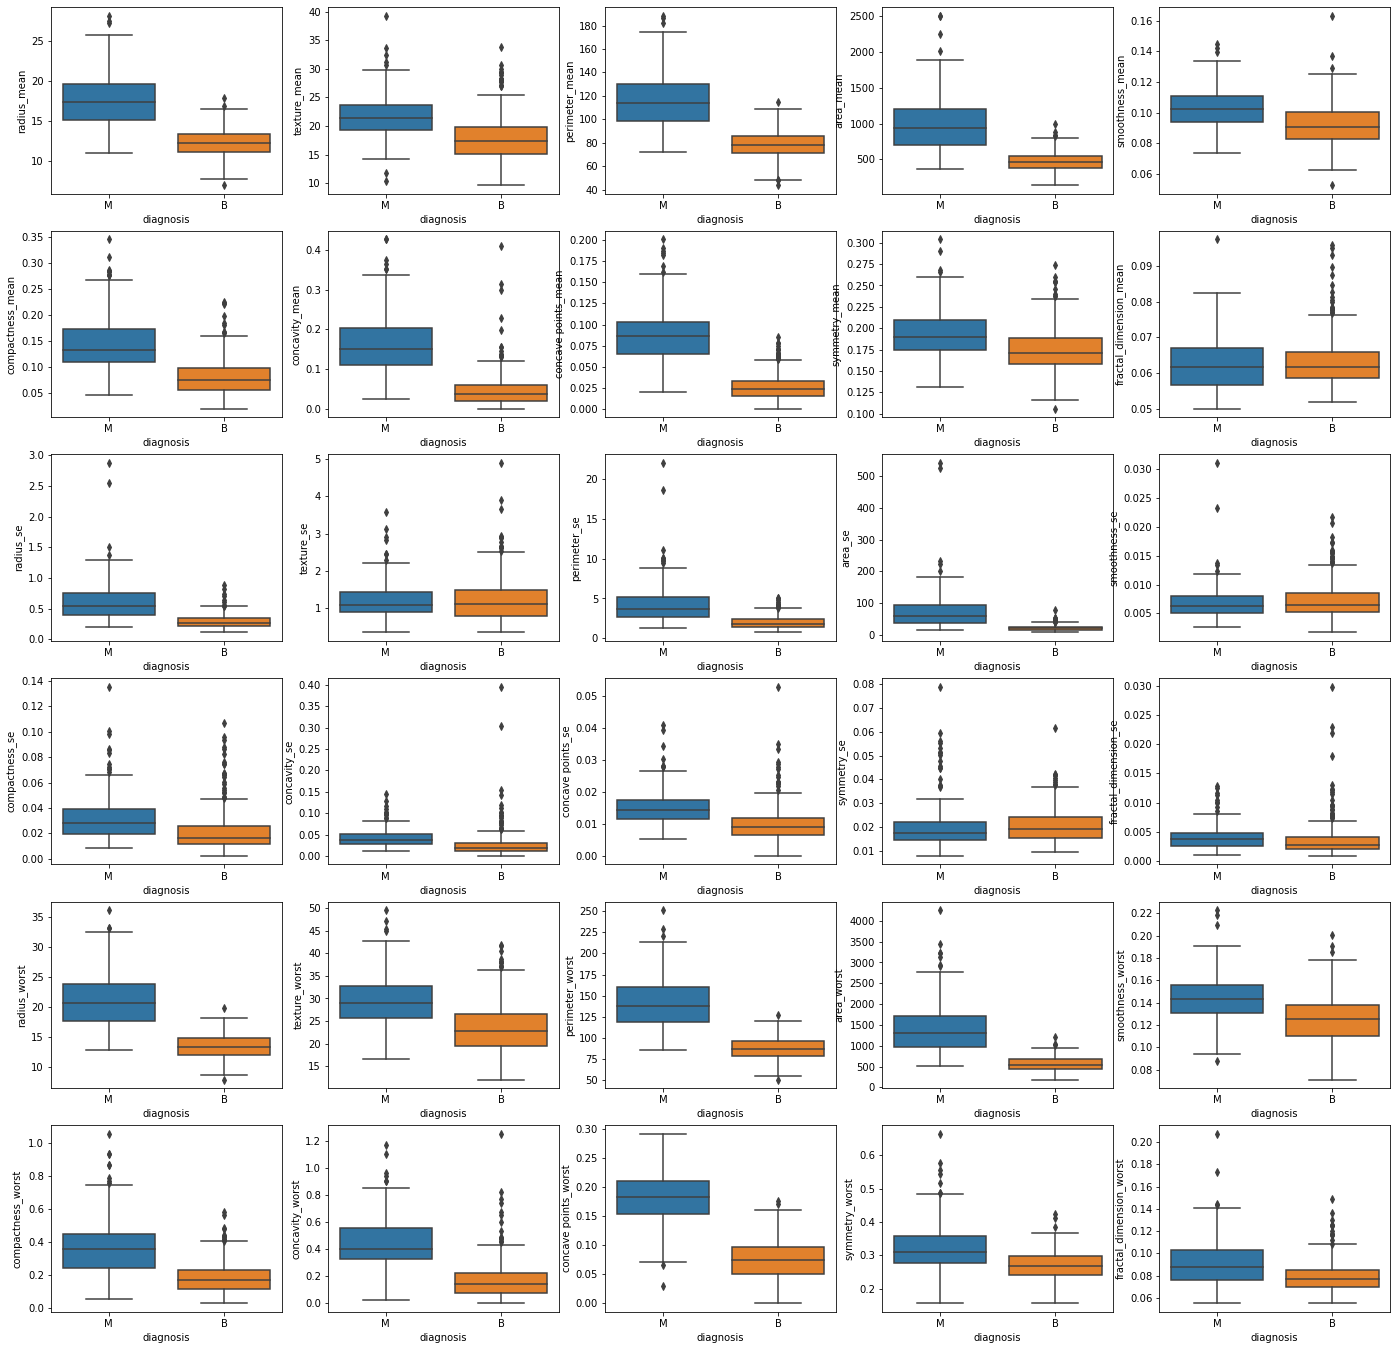

In [18]:
### Your code here
feature_names = cancer_X.columns.values.tolist()
fig, ax = plt.subplots(6,5,figsize = (24,24))
for var, subplot in zip(feature_names, ax.flatten()):
    sns.boxplot(x = cancer_y, y = var, data = cancer_df, ax = subplot)

### 2.2 Data Pre-processing

**Apply the following pre-processing steps to the breast cancer dataset:**

1. Encode the categorical label as 0 (B) or 1 (M).
2. Convert the label from a Pandas series to a Numpy (m x 1) vector. If you don't do this, it may cause problems when implementing the logistic regression model (certain broadcasting operations may fail unexpectedly).
2. Split the dataset into training (60%), validation (20%), and test (20%) sets.
3. Standardize the columns in the feature matrices cancer_X_train, cancer_X_val, and cancer_X_test to have zero mean and unit variance. To avoid information leakage, learn the standardization parameters (mean, variance) from cancer_X_train, and apply it to cancer_X_train, cancer_X_val, and cancer_X_test.
4. Add a column of ones to the feature matrices cancer_X_train, cancer_X_val, and cancer_X_test. This is a common trick so that we can learn a coefficient for the bias term of a linear model.


In [19]:
from sklearn.preprocessing import OrdinalEncoder
### Encode the categorical label as 0 (B) or 1 (M) and convert the label from a Pandas series to a Numpy (m x 1) vector.
enc = OrdinalEncoder(categories = [["B","M"]])
cancer_y_ord = enc.fit_transform(cancer_y.to_numpy().reshape(-1,1))
## Split the dataset into training (60%), validation (20%), and test (20%) sets.
cancer_X_dev, cancer_X_test, cancer_y_dev, cancer_y_test = train_test_split(
    cancer_X, cancer_y_ord, test_size=0.2, random_state=0)
cancer_X_train, cancer_X_val, cancer_y_train, cancer_y_val = train_test_split(
    cancer_X_dev, cancer_y_dev, test_size=0.25, random_state=0)

##Standardize the columns in the feature matrices cancer_X_train, cancer_X_val, and cancer_X_test to have zero mean and unit variance. 
scaler = StandardScaler()
cancer_X_train = scaler.fit_transform(cancer_X_train)   
cancer_X_val = scaler.transform(cancer_X_val)        
cancer_X_test = scaler.transform(cancer_X_test)         

## Add a column of ones to the feature matrices cancer_X_train, cancer_X_val, and cancer_X_test.
cancer_X_train = np.hstack([np.ones((cancer_X_train.shape[0], 1)), cancer_X_train])
cancer_X_val = np.hstack([np.ones((cancer_X_val.shape[0], 1)), cancer_X_val])
cancer_X_test = np.hstack([np.ones((cancer_X_test.shape[0], 1)), cancer_X_test])

print(cancer_X_test[:1], '\n\n', cancer_X_train[:1])


[[ 1.00000000e+00 -1.79677263e-01  3.57251467e-01 -1.09299955e-01
  -2.50674971e-01  9.73278634e-01  8.88570489e-01  7.48291965e-01
   8.68087149e-01  1.17463962e+00  1.51158327e+00  1.14410602e-03
  -4.81894977e-01  1.66575660e-01 -1.07298907e-01 -5.50954009e-01
  -9.94602758e-02  1.12103950e-01  3.25486524e-01 -4.06658827e-01
   1.43499041e-01  5.99719788e-02  7.02725773e-01  2.13857746e-01
  -3.67106525e-02  1.03002388e+00  8.85834510e-01  1.20681823e+00
   1.38934651e+00  1.07782439e+00  1.47925930e+00]] 

 [[ 1.          1.50187685  1.07838252  1.53928779  1.39584697  0.41294933
   1.06716482  1.51924125  1.05127403  0.65598447 -0.40216579  0.46357087
   1.08683683  0.62073581  0.42853893  1.20796834  0.50364916  0.25393119
   0.69693982  0.198902    0.12086794  1.14649322  0.84726404  1.15860464
   0.96153423  0.54824133  0.30478439  0.39323692  0.65166982  0.01530304
  -0.42081625]]


At the end of this pre-processing, you should have the following vectors and matrices: cancer_X_train, cancer_X_val, cancer_X_test, cancer_y_train, cancer_y_val, cancer_y_test.

### 2.3 Implement Logistic Regression

We will now implement logistic regression with L2 regularization. Given an (m x n) feature matrix $X$, an (m x 1) label vector $y$, and an (n x 1) weight vector $w$, the hypothesis function for logistic regression is:

$$
y = \sigma(X w)
$$

where $\sigma(x) = \frac{1}{1 + e^{-x}}$, i.e. the sigmoid function. This function scales the prediction to be a probability between 0 and 1, and can then be thresholded to get a discrete class prediction.

Just as with linear regression, our objective in logistic regression is to learn the weights $𝑤$ which best fit the data. For L2-regularized logistic regression, we find an optimal $w$ to minimize the following loss function:

$$
\min_{w} \ -y^T \ \text{log}(\sigma(Xw)) \ - \  (\mathbf{1} - y)^T \ \text{log}(\mathbf{1} - \sigma(Xw)) \ + \ \alpha \| w \|^2_2 \\
$$

Unlike linear regression, however, logistic regression has no closed-form solution for the optimal $w$. So, we will use gradient descent to find the optimal $w$. The (n x 1) gradient vector $g$ for the loss function above is:

$$
g = X^T \Big(\sigma(Xw) - y\Big) + 2 \alpha w
$$

Below is pseudocode for gradient descent to find the optimal $w$. You should first initialize $w$ (e.g. to a (n x 1) zero vector). Then, for some number of epochs $t$, you should update $w$ with $w - \eta g $, where $\eta$ is the learning rate and $g$ is the gradient. You can learn more about gradient descent [here](https://www.coursera.org/lecture/machine-learning/gradient-descent-8SpIM).

> $w = \mathbf{0}$
> 
> $\text{for } i = 1, 2, ..., t$
>
> $\quad \quad w = w - \eta g $


**Implement a `LogisticRegression` class with five methods: `train`, `predict`, `calculate_loss`, `calculate_gradient`, and `calculate_sigmoid`.** You may NOT use sklearn for this implementation. It is highly recommended that you vectorize your code.

In [20]:
from numpy import linalg
class LogisticRegression():
    '''
    Logistic regression model with L2 regularization.

    Attributes
    ----------
    alpha: regularization parameter
    t: number of epochs to run gradient descent
    eta: learning rate for gradient descent
    w: (n x 1) weight vector
    '''
    
    def __init__(self, alpha=0, t=100, eta=1e-3):
        self.alpha = alpha
        self.t = t
        self.eta = eta
        self.w = None

    def train(self, X, y):
        '''Trains logistic regression model using gradient descent 
        (sets w to its optimal value).
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        losses: (t x 1) vector of losses at each epoch of gradient descent
        '''
        ### Your code here
        self.m, self.n = X.shape ##get m and n
        self.X = X
        self.y = y
        self.w = np.zeros((self.n,1)) 
        self.temp = float("inf")
        self.trainloss = [None] * self.t
        for i in range(self.t) :
            self.trainloss[i]=self.calculate_loss(self.X, self.y).item()
            if self.calculate_loss(self.X, self.y) < self.temp:
                self.temp = self.calculate_loss(self.X, self.y)
                self.w = self.w - np.dot(self.eta,self.calculate_gradient(self.X,self.y))
        return self.w
    
    def predict(self, X):
        '''Predicts on X using trained model. Make sure to threshold 
        the predicted probability to return a 0 or 1 prediction.
        
        Parameters
        ----------
        X : (m x n) feature matrix
        
        Returns
        -------
        y_pred: (m x 1) 0/1 prediction vector
        '''
        ### Your code here
        self.X = X
        self.Y = self.calculate_sigmoid(np.dot(self.X,self.w))
        self.y_pred = np.where( self.Y > 0.5, 1, 0 )
        return self.y_pred
    
    def calculate_loss(self, X, y):
        '''Calculates the logistic regression loss using X, y, w, 
        and alpha. Useful as a helper function for train().
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        loss: (scalar) logistic regression loss
        '''
        self.X = X
        self.y = y
        self.loss = -np.dot(self.y.T, np.log(self.calculate_sigmoid(np.dot(self.X,self.w))))-np.dot((np.ones((self.m,1))-self.y).T, np.log(np.ones((self.m,1))-self.calculate_sigmoid(np.dot(self.X,self.w))))+ np.dot(self.alpha, np.linalg.norm(self.w))
        return self.loss
    
    def calculate_gradient(self, X, y):
        '''Calculates the gradient of the logistic regression loss 
        using X, y, w, and alpha. Useful as a helper function 
        for train().
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        gradient: (n x 1) gradient vector for logistic regression loss
        '''
        ### Your code here
         
        self.X = X
        self.y = y
        self.g = np.dot(self.X.T,(self.calculate_sigmoid(np.dot(self.X,self.w))-self.y) ) + np.dot(2*self.alpha,self.w)
        return self.g
    
    def calculate_sigmoid(self, x):
        '''Calculates the sigmoid function on each element in vector x. 
        Useful as a helper function for predict(), calculate_loss(), 
        and calculate_gradient().
        
        Parameters
        ----------
        x: (m x 1) vector
        
        Returns
        -------
        sigmoid_x: (m x 1) vector of sigmoid on each element in x
        '''
        self.x = x
        self.sigmoid_x = 1 / (1 + np.exp(-self.x))
        return self.sigmoid_x
    
        ### Your code here
   

### 2.4 Train, Evaluate, and Interpret Logistic Regression Model

**Using your implementation above, train a logistic regression model (alpha=0, t=100, eta=1e-3) on the breast cancer training data. Plot the training loss over epochs. Make sure to label your axes.** You should see the loss decreasing and start to converge.

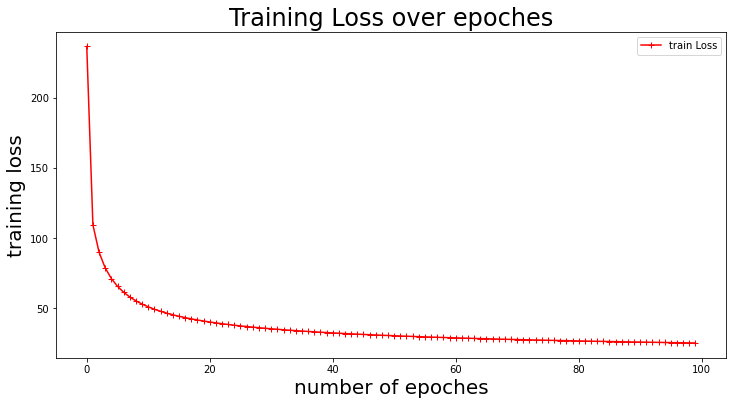

In [21]:
### Your code here
LR = LogisticRegression()
LR.train(cancer_X_train, cancer_y_train)
epoch = [i for i in range(100)]
fig = plt.figure(figsize = (12,6))
plt.plot(epoch, LR.trainloss, "r+-",label = "train Loss")
plt.legend()
plt.xlabel('number of epoches', fontsize=20)
plt.ylabel('training loss', fontsize=20)
plt.title('Training Loss over epoches', fontsize=24)
plt.show()

In [31]:
cancer_y_train

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],

**Use your trained model to make predictions and report the accuracy on the training, validation, and test sets. Report the first 5 predictions on the test set, along with the actual labels.** Your accuracies should be much higher than the baseline accuracy we found in Section 2.1.

In [22]:
### Your code here
LR.predict(cancer_X_train)
LR.predict(cancer_X_val)
LR.predict(cancer_X_test)
def accuracy(x,y,ds):
    Y_pred = LR.predict(x)    
    correctly_classified = 0           
    count = 0    
    for count in range(np.size(Y_pred)) :  
        if y[count] == Y_pred[count] :            
            correctly_classified = correctly_classified + 1

        count = count + 1

    print( "Accuracy on", ds,"set by our model  :  ", (correctly_classified / count ) * 100 )

accuracy(cancer_X_train,cancer_y_train,"train")
accuracy(cancer_X_val,cancer_y_val,"validation")
accuracy(cancer_X_test,cancer_y_test,"test")
print("First 5 Prediction for test set:", LR.predict(cancer_X_test)[:5].tolist())
print("First 5 actual labels for test set:", np.array(cancer_y_test[:5]).tolist())

Accuracy on train set by our model  :   98.82697947214076
Accuracy on validation set by our model  :   96.49122807017544
Accuracy on test set by our model  :   95.6140350877193
First 5 Prediction for test set: [[1], [0], [0], [0], [0]]
First 5 actual labels for test set: [[1.0], [0.0], [0.0], [0.0], [0.0]]


**Interpret your trained model using a bar chart of the model weights.** Make sure to label the bars (x-axis) and don't forget the bias term! Use lecture 3, slide 15 as a reference.

Text(0.5, 1.0, 'Bar chart of the model weights')

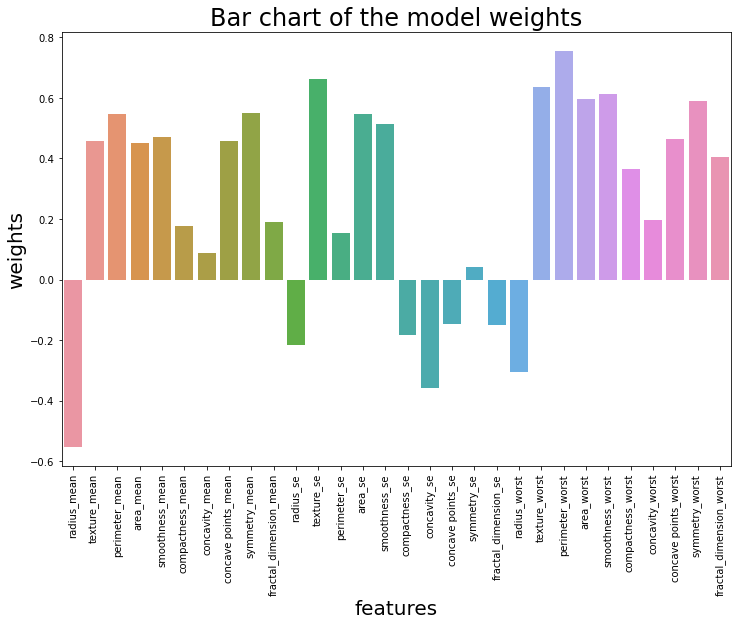

In [23]:
### Your code here
feature_names = cancer_X.columns.values.tolist()
feature_names
LR.w.T.flatten().tolist()
plt.figure(figsize = (12,8))
ax = sns.barplot(x = feature_names, y= LR.w.T.flatten()[:30])
ax.tick_params(axis="x",rotation = 90)
plt.ylabel('weights', fontsize=20)
plt.xlabel('features', fontsize=20)
plt.title('Bar chart of the model weights', fontsize=24)


**According to your model, which features are the greatest contributors to the diagnosis?**

In [24]:
### Your answer here

'''
From the above visualization, it seems that perimeter_worst is the most greatest contributor to the diagnosis. Some other 
important contributors are radius_mean, texture_se, etc.
'''

'\nFrom the above visualization, it seems that perimeter_worst is the most greatest contributor to the diagnosis. Some other \nimportant contributors are radius_mean, texture_se, etc.\n'

### 2.5 Tune Regularization Parameter  𝛼

Now, we will observe the effect of tuning the regularization parameter $\alpha$ on the learned weights of the model.

**Sweep out values for $\alpha$ using `alphas = np.logspace(-2, 2, 100)`. For each $\alpha$ value, train a logistic regression model and record its weights. Plot the weights for each feature as a function of $\alpha$ on a single figure. Make sure to label the axes.** You should have 31 curves (one for each feature) in the plot.

<ipython-input-25-9899e014860b>:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if weights == []:
<ipython-input-25-9899e014860b>:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if weights == []:


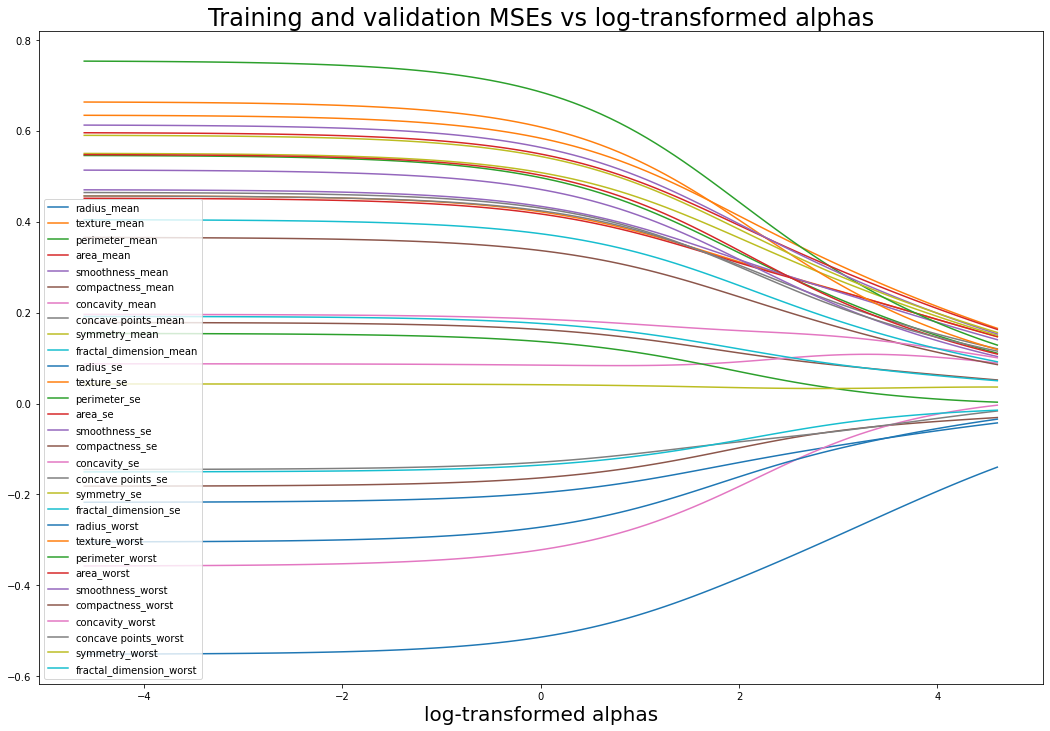

In [25]:
### Your code here
alphas = np.logspace(-2, 2, 100)
weights= []

for num,ele in enumerate(alphas):
    LR = LogisticRegression(alpha = ele)
    LR.train(cancer_X_train, cancer_y_train)
    if weights == []:
        weights = LR.w
    else:
        weights = np.concatenate((weights, LR.w), axis=1)
weights[1]
fig = plt.figure(figsize = (18,12))
for i in range(30):
    plt.plot(np.log(alphas), weights[i],label = feature_names[i])
plt.legend()
plt.xlabel('log-transformed alphas', fontsize=20)
plt.title('Training and validation MSEs vs log-transformed alphas', fontsize=24)
plt.show()

**Describe the effect of the regularization parameter $\alpha$ on the weights of your model. Please explain in terms of model complexity.**

In [26]:
### Your answer here

'''
We can clearly see from the above plots that when we increase the parameter 𝛼, the weights of our models gradually decreases,
meaning the complexity of the model is decreasing since the coeffcients of the features gradually converge to 0.

'''

'\nWe can clearly see from the above plots that when we increase the parameter 𝛼, the weights of our models gradually decreases,\nmeaning the complexity of the model is decreasing since the coeffcients of the features gradually converge to 0.\n\n'

## Part 3: SVM

You are allowed to use sklearn or any ML library in this part.

### 3.1 Train Primal SVM

**Train a primal SVM (with default parameters) on the breast cancer training data. Make predictions and report the accuracy on the training, validation, and test sets.**

In [27]:
### Your code here
from sklearn.svm import LinearSVC
LinearSVC = LinearSVC(loss = "hinge")
LinearSVC.fit(cancer_X_train,cancer_y_train.ravel())
print(f"Primal SVM accuracy on training data set:",LinearSVC.score(cancer_X_train, cancer_y_train.ravel()))
print(f"Primal SVM accuracy on validation data set:",LinearSVC.score(cancer_X_val, cancer_y_val.ravel()))
print(f"Primal SVM accuracy on test data set:",LinearSVC.score(cancer_X_test, cancer_y_test.ravel()))

Primal SVM accuracy on training data set: 0.9912023460410557
Primal SVM accuracy on validation data set: 0.9473684210526315
Primal SVM accuracy on test data set: 0.9649122807017544


### 3.2 Train Dual SVM

**Train a dual SVM (with default parameters) on the breast cancer training data. Make predictions and report the accuracy on the training, validation, and test sets.**

In [28]:
### Your code here
from sklearn.svm import SVC
dualsvm = SVC(kernel = "linear")
dualsvm.fit(cancer_X_train,cancer_y_train.ravel())
print(f"dual SVM accuracy on training data set:",dualsvm.score(cancer_X_train, cancer_y_train.ravel()))
print(f"dual SVM accuracy on validation data set:",dualsvm.score(cancer_X_val, cancer_y_val.ravel()))
print(f"dual SVM accuracy on test data set:",dualsvm.score(cancer_X_test, cancer_y_test.ravel()))

dual SVM accuracy on training data set: 0.9912023460410557
dual SVM accuracy on validation data set: 0.9473684210526315
dual SVM accuracy on test data set: 0.9649122807017544


### 3.3 Number of Support Vectors

**Find the number of support vectors in your SVM model.**

In [29]:
### Your code here
dualsvm.support_vectors_.shape


(29, 31)

### 3.4 Hyperparameter Tuning

**Improve the SVM model (by hyperparameter tuning, feature selection, or using a non-linear SVM) to get better test performance than the dual SVM.**

In [30]:
### Your code here
C = np.logspace(-3,3,20)
params = []
testscore = []
for ind,ele in enumerate(C):
    dualsvm = SVC(C= ele, kernel = "linear")
    dualsvm.fit(cancer_X_train,cancer_y_train.ravel())
    testscore.append(dualsvm.score(cancer_X_test, cancer_y_test.ravel()))
    params.append(ele)
print(f"Better test performance for the SVM Model is",max(testscore))

Better test performance for the SVM Model is 0.9736842105263158
